In [1]:
from datasets import CXRDataset
import numpy as np

In [2]:
IMG_DIR = './CXR8/Images'
TRAIN_LIST_FILE = './CXR8/Labels/train_list.txt'
VAL_LIST_FILE = './CXR8/Labels/val_list.txt'
TEST_LIST_FILE = './CXR8/Labels/test_list.txt'
AUX_LIST_FILE = './CXR8/Labels/aux_train_list.txt'

In [6]:
import cv2

img = cv2.imread('./CXR8/Images/00012413_002.png', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_AREA)
img = img / 255.0
img = img.astype(np.float32).reshape(1, 512, 512, 3)

print(img.shape)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:692: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'cv::imwrite_'


In [3]:
CLASS_NAMES = [
    'Atelectasis', 'Cardiomegaly', 'Effusion',
    'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
    'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema',
    'Fibrosis', 'Pleural_Thickening', 'Hernia'
]

labels = [
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
]

index = 2
dis = np.array(list(map(CLASS_NAMES.__getitem__, np.nonzero(labels[index])[0])))

print(dis if len(dis) != 0 else ['Normal'])

['Atelectasis' 'Cardiomegaly']


In [3]:
val = CXRDataset(IMG_DIR, AUX_LIST_FILE, resize=(512, 512))
val.load()
print(val)

val.print_img(0)
val.print_img(1)
val.print_img(2)

load took 1.584770679473877[s] to execute.

----------CXR Dataset----------
No.Examples: 100
No.Clases: 14
Image shapes: (512, 512, 3)
TfDataset
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(device_lib.list_local_devices())

tf.sysconfig.get_build_info()

Num GPUs Available:  0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4541221240871342100
xla_global_id: -1
]


OrderedDict([('is_cuda_build', False),
             ('is_rocm_build', False),
             ('is_tensorrt_build', False),
             ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll')])

Num GPUs Available:  0
Loading train data...
Loading validation data...
25/25 [==============================] - 164s 6s/step - loss: 7.1704 - accuracy: 0.1500 - val_loss: 0.2209 - val_accuracy: 0.5000 - lr: 0.0010
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                            

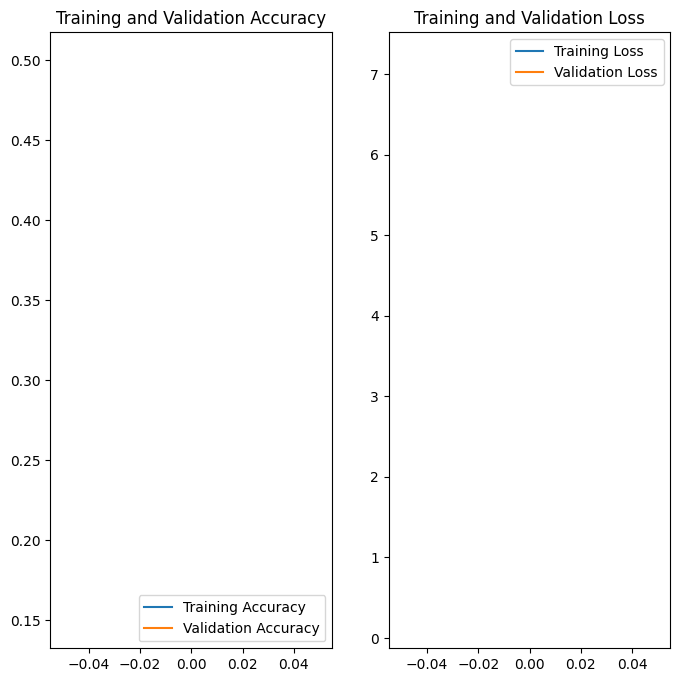

In [7]:
from nets.vgg_net import TransferVGG
from datasets import CXRDataset

import tensorflow as tf
import numpy as np
import cv2


IMG_DIR = './CXR8/Images'
TRAIN_LIST_FILE = './CXR8/Labels/aux_train_list.txt'
VAL_LIST_FILE = './CXR8/Labels/aux_val_list.txt'
TEST_LIST_FILE = './CXR8/Labels/test_list.txt'

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


print('Loading train data...')
train_gen = CXRDataset(
    IMG_DIR,
    TRAIN_LIST_FILE,
    batch_size=4,
    resize=(512, 512)
)

print('Loading validation data...')
val_gen = CXRDataset(
    IMG_DIR,
    VAL_LIST_FILE,
    batch_size=4,
    resize=(512, 512)
)

# ----- TransferVGG Training and Evaluation ----- #
model_vgg = TransferVGG()
model_vgg.build_top(fine_tuning=True)
model_vgg.compile(lr=1e-3)
model_vgg.train(
    train_gen,
    val_gen,
    batch_size=4, epochs=1,
    save=False, verbose=True
)

In [19]:
import keras.backend as K


def class_activation_mapping(model, original_img, target_class=1):
    # a = self.model.layers[-3].output[0]
    # w = self.model.layers[-1].get_weights()[0]
    # return tf.matmul(a, w)

    w, h, _ = original_img.shape
    # img = np.array([np.transpose(np.float32(original_img), (2, 0, 1))])
    img = original_img.reshape(1, 512, 512, 3)

    class_weights = model.layers[-1].get_weights()[0]
    transition_layer = model.layers[-3]

    get_output = K.function(
        [model.layers[0].input],
        [
            transition_layer.output,
            model.layers[-1].output
        ]
    )
    [transition_outputs, predictions] = get_output([img])
    transition_outputs = transition_outputs[0, :, :, :]

    cam = np.zeros(dtype=np.float32, shape=transition_outputs.shape[1:3])
    print(class_weights[target_class, :].shape)
    for i, w in enumerate(class_weights[target_class, :]):
        cam += w * transition_outputs[i, :, :]

    cam = cv2.resize(cam, (512, 512))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    original_img = original_img[0, :]
    original_img -= np.min(original_img)
    original_img = np.minimum(original_img, 255)

    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(original_img)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap

In [24]:
img = cv2.imread('./CXR8/Images/00012413_002.png', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_AREA)
img = img / 255.0
img = img.astype(np.float32)

pred = model_vgg.model.predict(img.reshape(1, 512, 512, 3))
print(pred)
pred_class = np.argmax(pred)
print(pred_class)

cam, heatmap = class_activation_mapping(model_vgg.model, img, pred_class)

cv2.imshow('img', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
cv2.imshow("cam", cam)
cv2.imshow("heatmap", heatmap)

cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 0s 381ms/step
[[0.28038198 0.00804749 0.06537315 0.01383111 0.03108016 0.13616557
  0.0052133  0.265906   0.00898886 0.0485302  0.0560853  0.06754944
  0.01245807 0.00038938]]
0
(14,)
